### Business Problem:
### One of the global banks would like to understand what factors driving credit card spend are. The bank want use these insights to calculate credit limit. In order to solve the problem, the bank conducted survey of 5000 customers and collected data.
### The objective of this case study is to understand what's driving the total spend (Primary Card + Secondary card). Given the factors, predict credit limit for the new applicants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

In [2]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [4]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [5]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [6]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [7]:
### Data import

In [8]:
df_cust_db=pd.read_excel('F:/analytix_labs/1. Predicting Credit Card Spend & Identifying Key Drivers/Data_Set.xlsx')

In [9]:
df_cust_db.head(10)

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0
5,9662-FUSYIM-1IV,4,4.0,0,64,5,August,17,4,3,...,1,1,0,0,0,0,0,0,1,0
6,7432-QKQFJJ-K72,2,5.0,1,52,5,July,14,2,1,...,1,0,1,1,0,0,0,0,0,0
7,8959-RZWRHU-ST8,3,4.0,1,44,4,October,16,3,1,...,1,0,0,0,0,0,1,0,0,0
8,9124-DZALHM-S6I,2,3.0,1,66,6,October,12,2,1,...,1,0,0,0,0,0,0,1,0,0
9,3512-MUWBGY-52X,2,2.0,0,47,4,July,11,1,6,...,1,0,0,0,0,0,0,0,0,0


In [17]:
df_cust_db.info(verbose= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 130 columns):
custid               object
region               int64
townsize             float64
gender               int64
age                  int64
agecat               int64
birthmonth           object
ed                   int64
edcat                int64
jobcat               int64
union                int64
employ               int64
empcat               int64
retire               int64
income               int64
lninc                float64
inccat               int64
debtinc              float64
creddebt             float64
lncreddebt           float64
othdebt              float64
lnothdebt            float64
default              int64
jobsat               int64
marital              int64
spoused              int64
spousedcat           int64
reside               int64
pets                 int64
pets_cats            int64
pets_dogs            int64
pets_birds           int64
pets_reptile

### Seperate Categorical and continous Variables

In [10]:
df_cust_cont=df_cust_db.loc[:,df_cust_db.columns.difference(['carown','cartype','carcatvalue','carbought','carbuy','commute','commutecat','commutecar','commutemotorcycle','commutecarpool',	
'card2fee','card2tenure','card2tenurecat','active','bfast','churn','tollfree','equip','callcard','wireless','multline',
'region','townsize','gender','agecat','birthmonth','edcat','jobcat','union',
'employ','empcat','retire','commutebus','commuterail','commutepublic','commutebike',
'commutewalk','commutenonmotor','telecommute','reason','polview','polparty','polcontrib','voice',
'pager','internet','callid','callwait',	'forward','confer','ebill','owntv','ownvcr','owndvd','inccat',
'default','jobsat','marital','spousedcat','homeown','hometype','address','addresscat','cars','vote',
'card','cardtype','cardbenefit','cardfee','cardtenure','cardtenurecat','card2','card2type','card2benefit',
'owncd','ownpda','ownpc','ownipod','owngame','ownfax','news','response_01','response_02','response_03']
)]

In [11]:
### Drop unnecessary Variables

In [12]:
df_cust_cont.drop(columns= 'custid',inplace =True)

In [13]:
df_cust_cat=df_cust_db.loc[:,['carown','cartype','carcatvalue','carbought','carbuy','commute','commutecat','commutecar','commutemotorcycle','commutecarpool',	
'card2fee','card2tenure','card2tenurecat','active','bfast','churn','tollfree','equip','callcard','wireless','multline',
'region','townsize','gender','agecat','birthmonth','edcat','jobcat','union',
'employ','empcat','retire','commutebus','commuterail','commutepublic','commutebike',
'commutewalk','commutenonmotor','telecommute','reason','polview','polparty','polcontrib','voice',
'pager','internet','callid','callwait','forward','confer','ebill','owntv','ownvcr','owndvd','inccat',
'default','jobsat','marital','spousedcat','homeown','hometype','address','addresscat','cars','vote',
'card','cardtype','cardbenefit','cardfee','cardtenure','cardtenurecat','card2','card2type','card2benefit',
'owncd','ownpda','ownpc','ownipod','owngame','ownfax','news','response_01','response_02','response_03']]

In [14]:
df_cust_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 84 columns):
carown               5000 non-null int64
cartype              5000 non-null int64
carcatvalue          5000 non-null int64
carbought            5000 non-null int64
carbuy               5000 non-null int64
commute              5000 non-null int64
commutecat           5000 non-null int64
commutecar           5000 non-null int64
commutemotorcycle    5000 non-null int64
commutecarpool       5000 non-null int64
card2fee             5000 non-null int64
card2tenure          5000 non-null int64
card2tenurecat       5000 non-null int64
active               5000 non-null int64
bfast                5000 non-null int64
churn                5000 non-null int64
tollfree             5000 non-null int64
equip                5000 non-null int64
callcard             5000 non-null int64
wireless             5000 non-null int64
multline             5000 non-null int64
region               5000 non-nu

### Variables Summary

In [15]:
cont_sum=df_cust_cont.apply(lambda x : continuous_var_summary(x))

In [16]:
cont_sum.to_excel('F:/analytix_labs/1. Predicting Credit Card Spend & Identifying Key Drivers/cont_sum.xlsx')

In [17]:
cat_sum=df_cust_cat.apply(lambda x : categorical_var_summary(x))

In [18]:
cat_sum.to_excel('F:/analytix_labs/1. Predicting Credit Card Spend & Identifying Key Drivers/cat_sum.xlsx')

In [19]:
### clip the continuous data

In [20]:
df_cust_cont = df_cust_cont.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.dropna().quantile(0.99)))

### missing value imputation

In [21]:
df_cust_cat.apply(lambda x : x.fillna(x.mode()))
df_cust_cont = df_cust_cont.apply(missing_imputation)

In [22]:
df_cust_cat['townsize']=df_cust_cat.townsize.fillna(1.0)

In [23]:
df_cust_cat.townsize.fillna(df_cust_cat.townsize.mode().astype('float64')).isnull().value_counts()

False    5000
Name: townsize, dtype: int64

In [24]:
def cat_count (x):
    sns.countplot(x)
    plt.show()

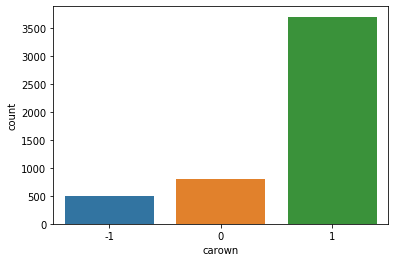

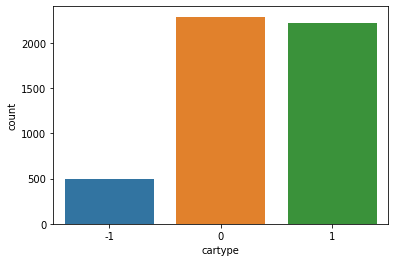

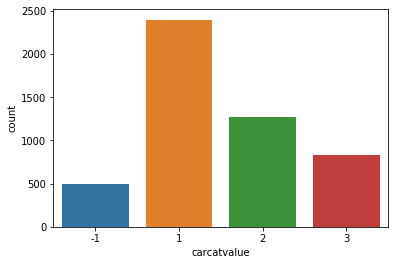

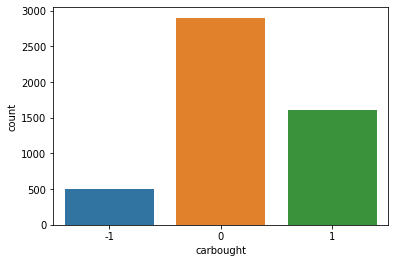

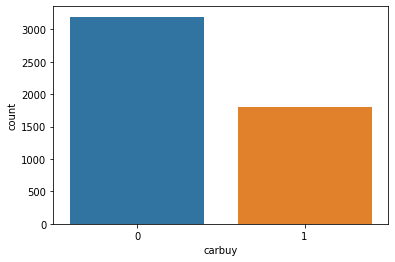

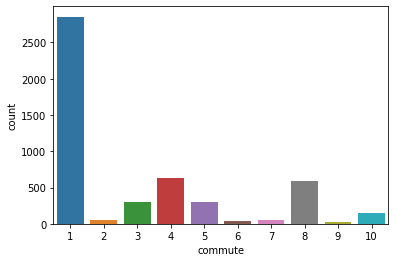

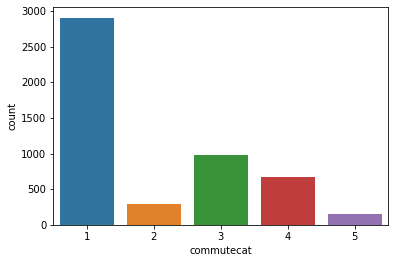

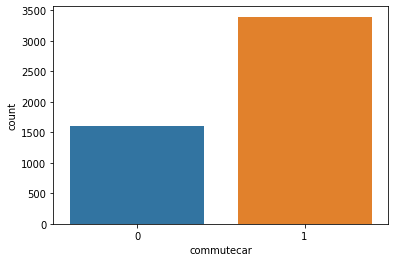

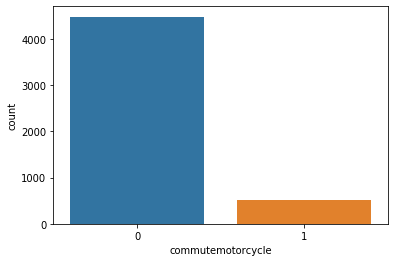

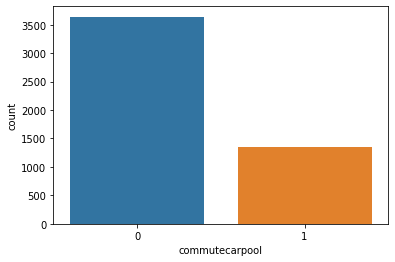

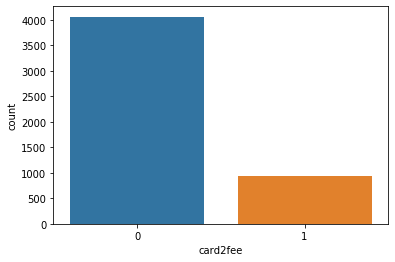

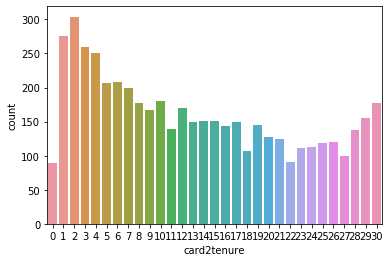

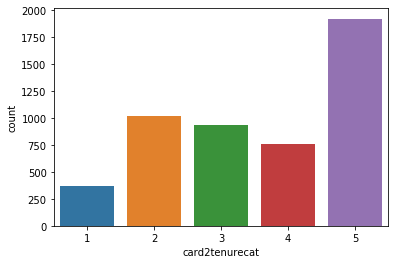

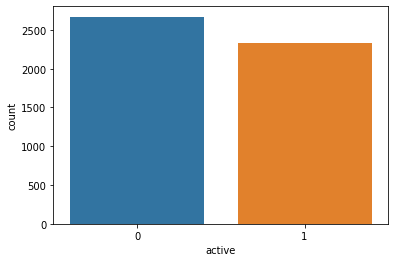

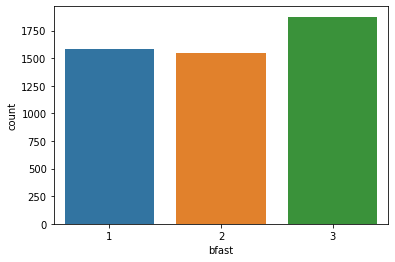

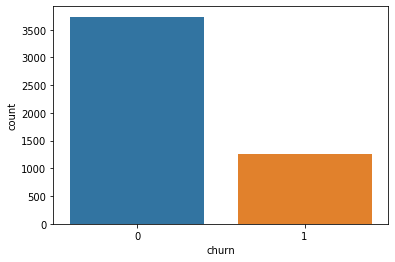

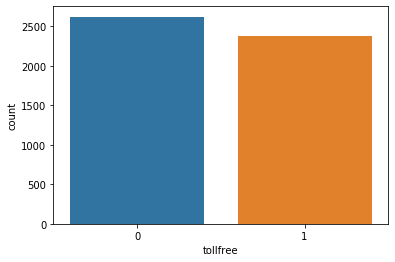

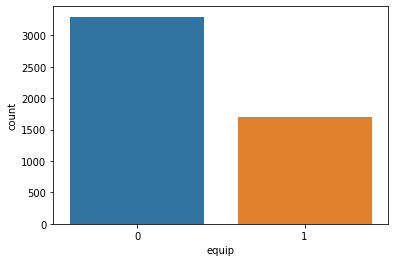

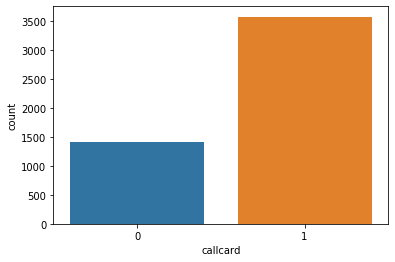

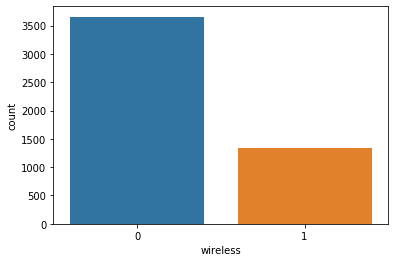

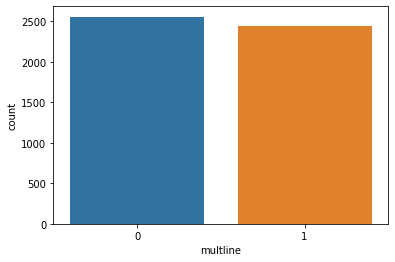

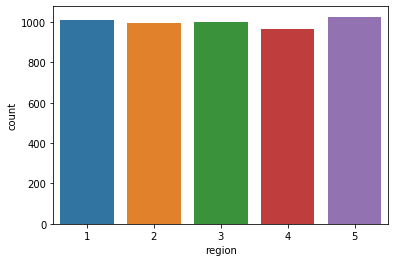

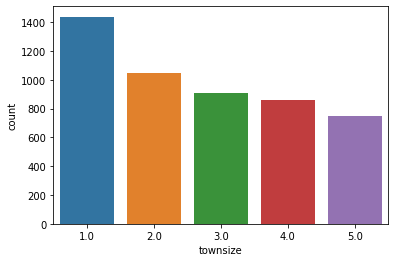

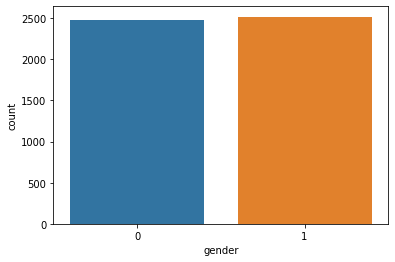

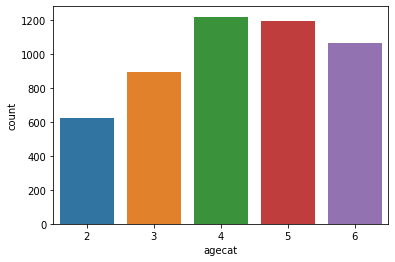

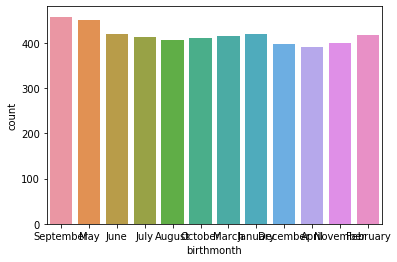

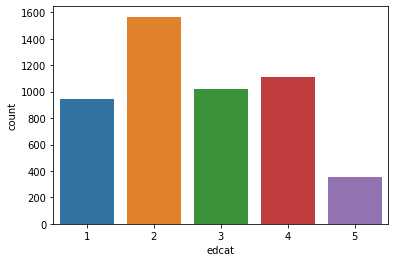

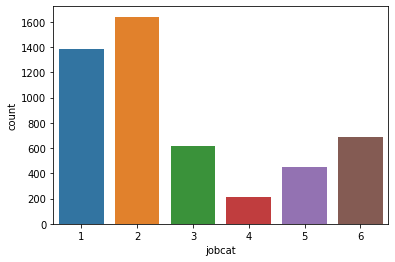

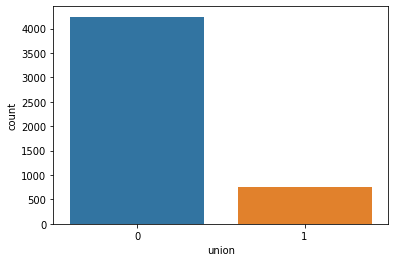

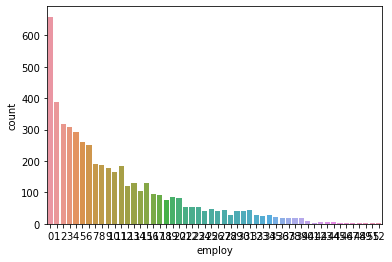

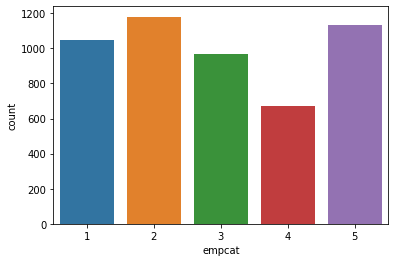

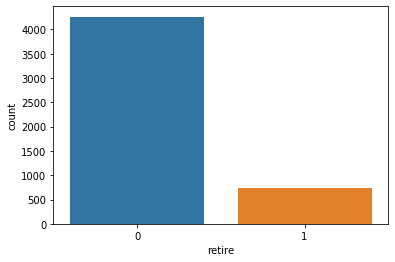

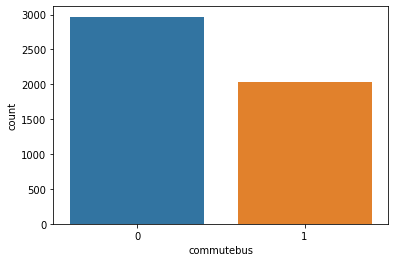

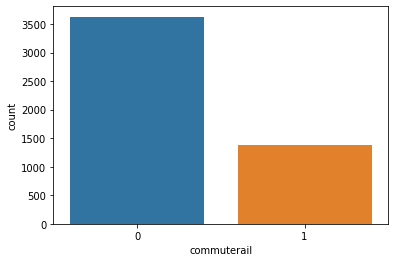

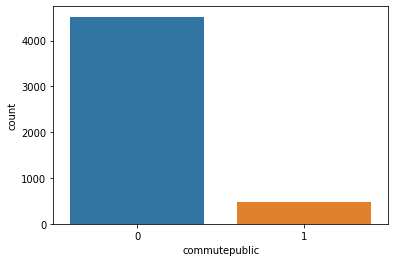

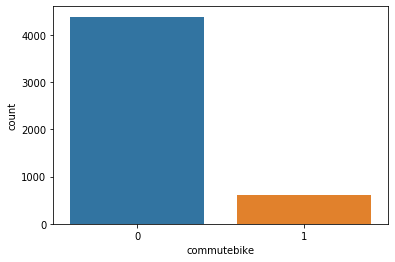

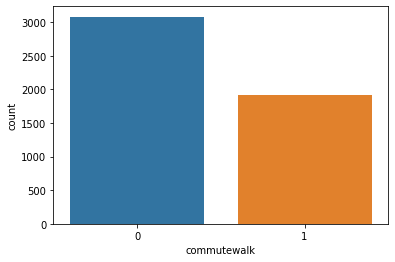

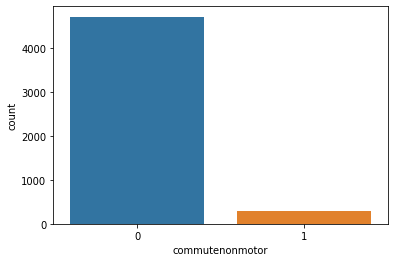

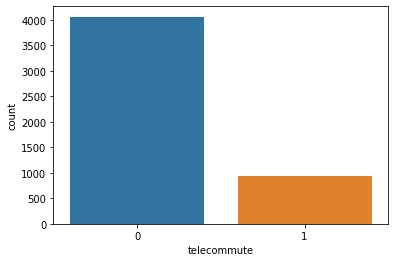

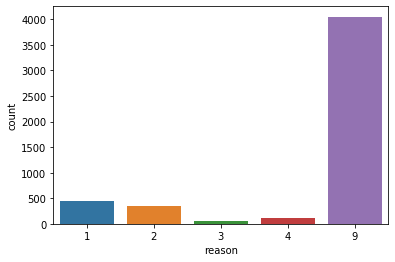

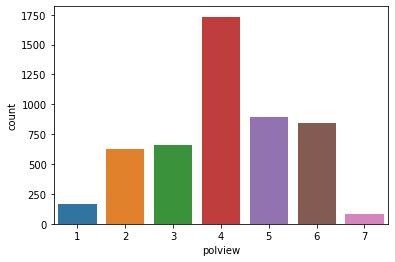

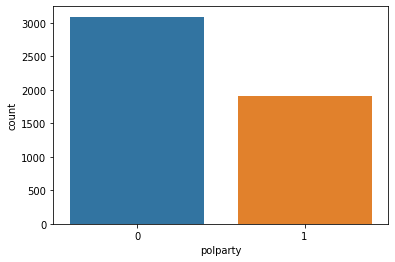

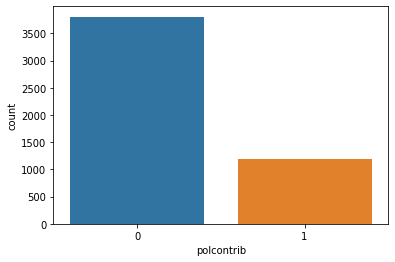

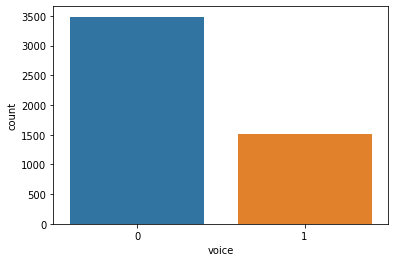

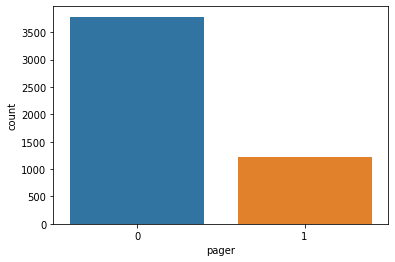

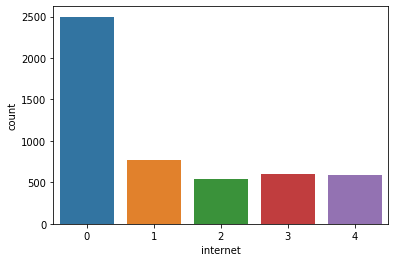

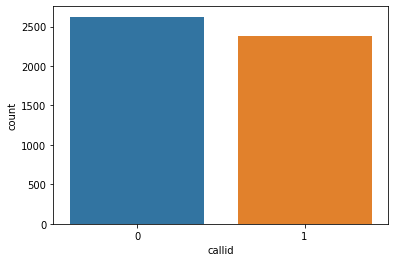

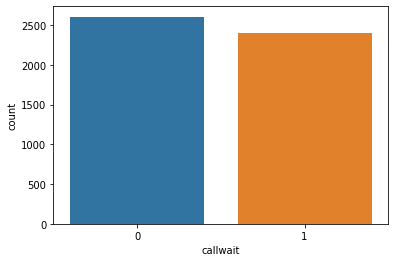

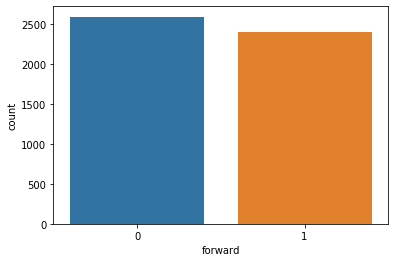

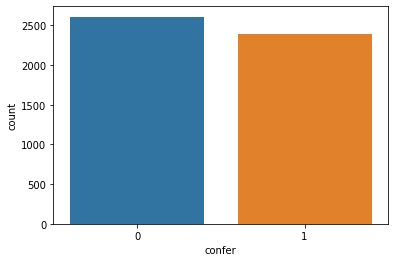

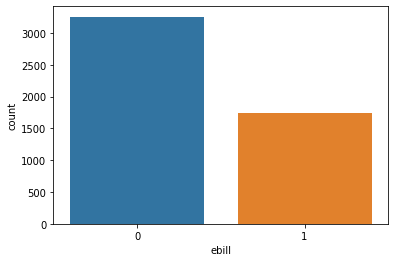

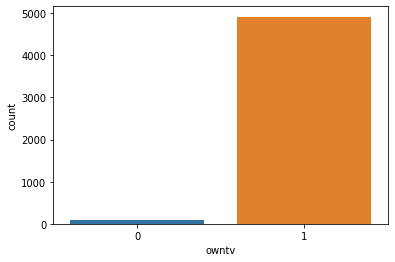

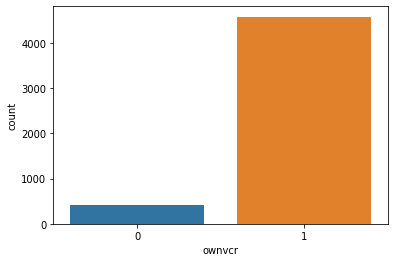

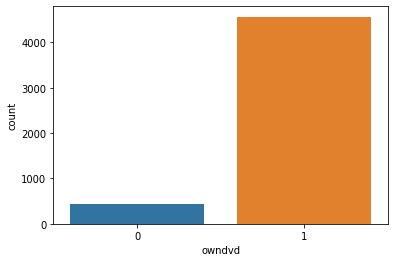

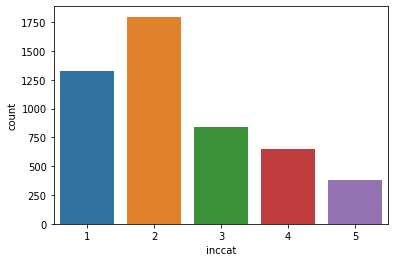

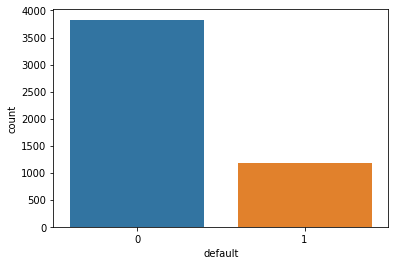

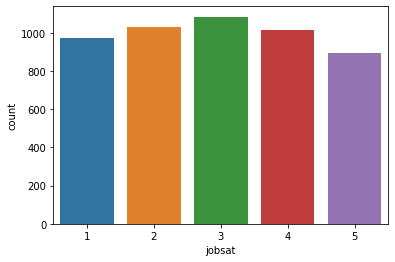

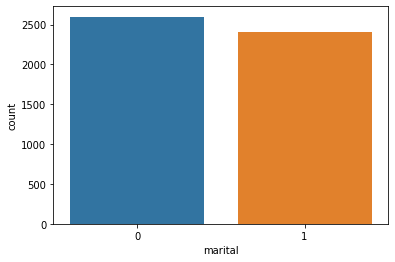

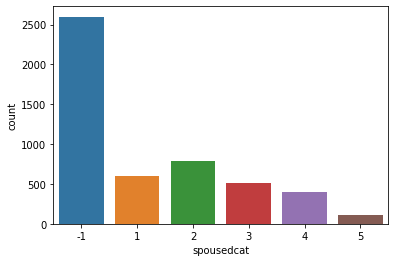

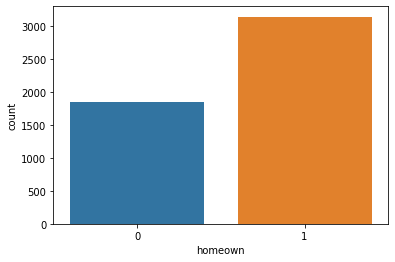

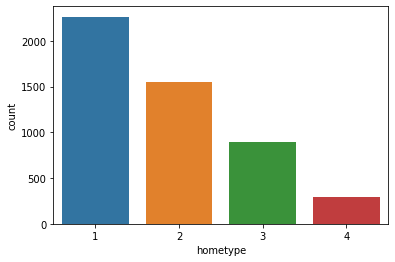

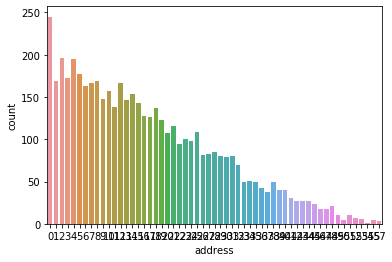

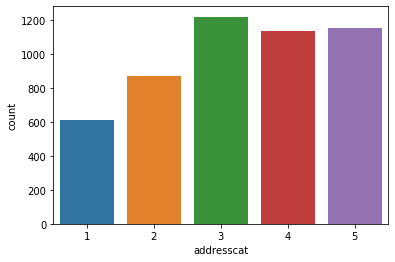

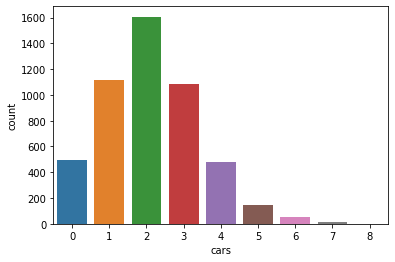

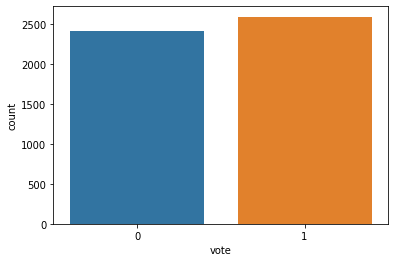

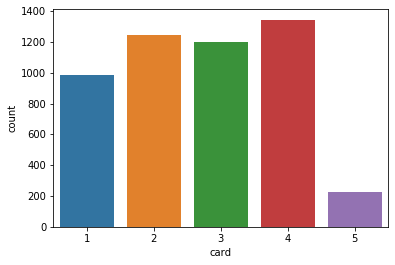

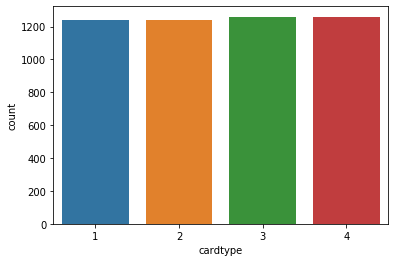

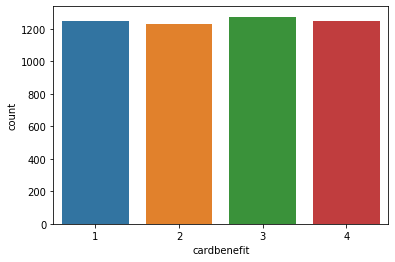

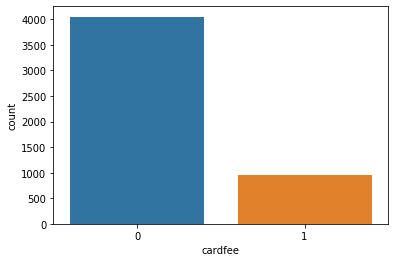

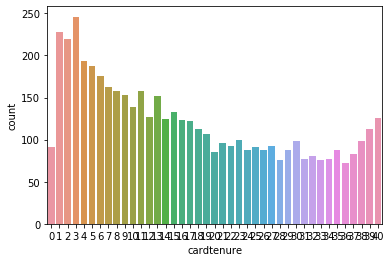

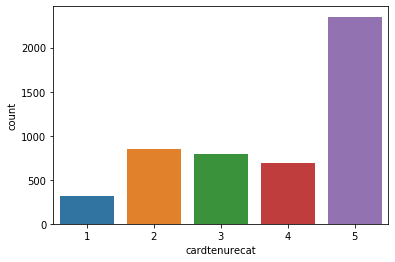

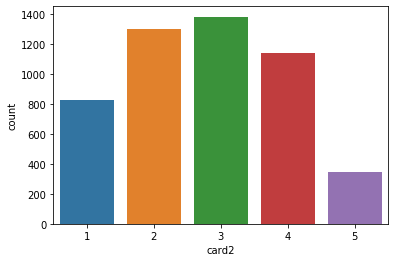

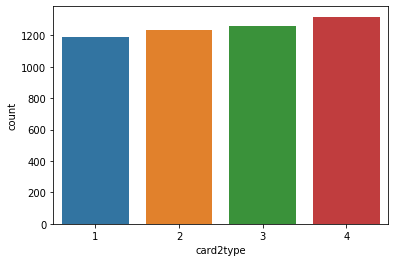

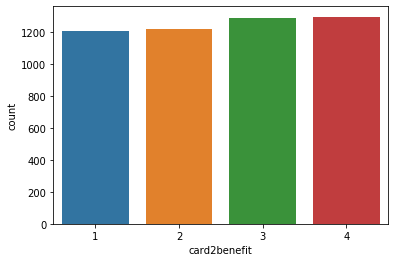

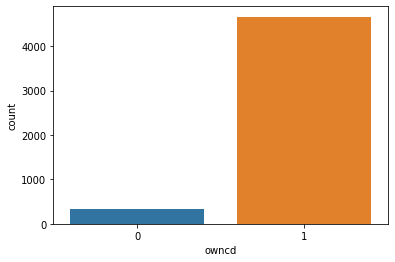

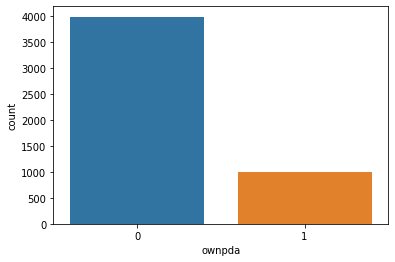

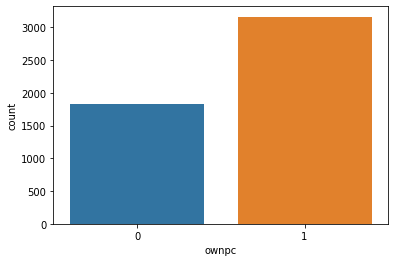

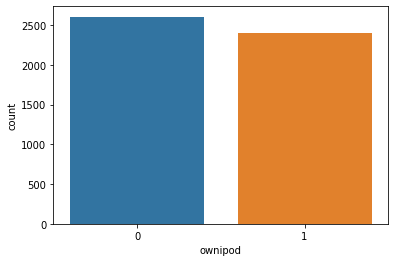

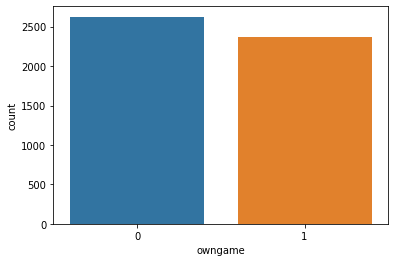

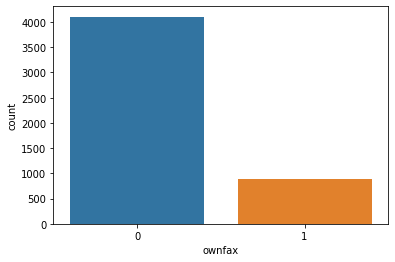

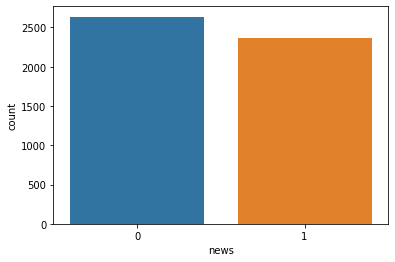

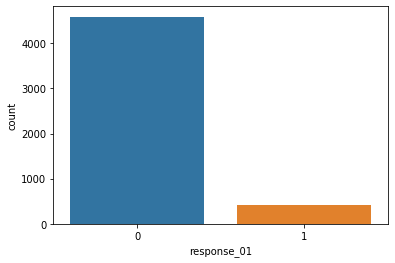

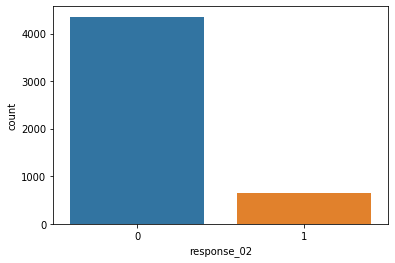

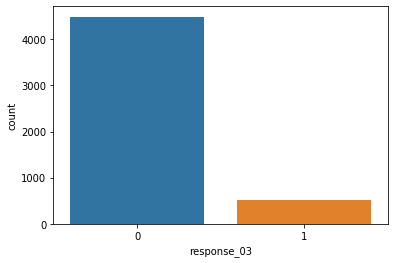

carown               None
cartype              None
carcatvalue          None
carbought            None
carbuy               None
commute              None
commutecat           None
commutecar           None
commutemotorcycle    None
commutecarpool       None
card2fee             None
card2tenure          None
card2tenurecat       None
active               None
bfast                None
churn                None
tollfree             None
equip                None
callcard             None
wireless             None
multline             None
region               None
townsize             None
gender               None
agecat               None
birthmonth           None
edcat                None
jobcat               None
union                None
employ               None
empcat               None
retire               None
commutebus           None
commuterail          None
commutepublic        None
commutebike          None
commutewalk          None
commutenonmotor      None
telecommute 

In [123]:
df_cust_cat.apply(cat_count)

In [25]:
### change the dtype of categorical variables to 'category'

In [26]:
df_cust_cat=df_cust_cat.astype('category')

In [27]:
df_cust_db_new=pd.concat([df_cust_cat,df_cust_cont],axis = 1)

In [28]:
df_cust_db_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 129 entries, carown to wireten
dtypes: category(84), float64(31), int64(14)
memory usage: 2.1 MB


In [29]:
corr_cust_db=df_cust_db_new.corr()

In [30]:
corr_cust_db.to_excel('F:/analytix_labs/1. Predicting Credit Card Spend & Identifying Key Drivers/corr_cust_db.xlsx')

### Determine the Target Variable

In [31]:
df_cust_db_new['crdspent']=df_cust_db_new['cardspent']+df_cust_db_new['card2spent']

In [32]:
df_cust_db_new[['crdspent','cardspent','card2spent']]

,crdspent,cardspent,card2spent
0,149.46,81.66,67.80
1,77.54,42.60,34.94
2,359.97,184.22,175.75
3,359.41,340.99,18.42
4,507.83,255.10,252.73
...,...,...,...
4995,1425.67,872.11,553.56
4996,366.35,210.81,155.54
4997,1527.75,884.08,643.67
4998,752.95,381.35,371.60


In [39]:
### drop unwanted variable

In [33]:
df_cust_db_new.drop(columns = 'birthmonth',inplace = True)

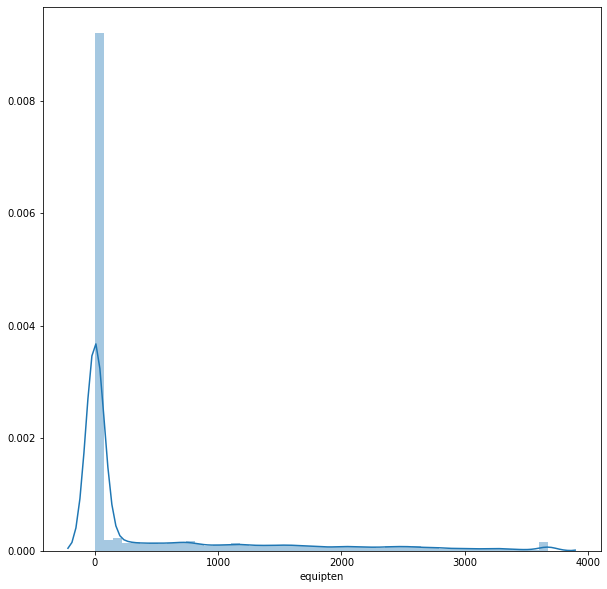

In [34]:
plt.figure(figsize= (10,10))
sns.distplot(df_cust_db_new['equipten'])

### F_regression for feature selection ( Significant Variable)

In [36]:
from sklearn.feature_selection import f_regression
df_cust_db_new['ln_crdspent']=np.log(df_cust_db_new['crdspent'])
df_cust_db_new['ln_debtinc']=np.log(df_cust_db_new['crdspent'])
features = df_cust_db_new.loc[:,df_cust_db_new.columns.difference(['cardspent', 'card2spent','ln_crdspent','crdspent'])]
target = np.log(df_cust_db_new['crdspent'])
F_values, p_values  = f_regression(features, target )

In [37]:
f_reg_results = pd.DataFrame(zip(list(features.columns),F_values.round(3), p_values.round(3)),columns=['Variable','F_Value', 'P_Value'])

In [38]:
features.to_excel('F:/analytix_labs/1. Predicting Credit Card Spend & Identifying Key Drivers/features.xlsx')

In [39]:
f_reg_results['Var_Sig']=np.where(f_reg_results.P_Value <= 0.1 , 'Sig', 'Insig')

In [40]:
l_feature=list(f_reg_results.Variable[f_reg_results['Var_Sig'] ==  'Sig'])

### Variance Inflation factor for remove multicolinearity

In [41]:
model_param='ln_crdspent ~ ' + ' + '.join(l_feature)

In [42]:
model_param

'ln_crdspent ~ address + addresscat + agecat + bfast + callid + callwait + carcatvalue + card + card2 + card2tenure + card2tenurecat + cardten + cardtenure + cardtenurecat + carown + carvalue + commutebike + confer + creddebt + ebill + ed + edcat + empcat + employ + equip + equipmon + equipten + forward + gender + homeown + hourstv + inccat + income + internet + jobsat + ln_debtinc + lncardten + lncreddebt + lnequipmon + lnequipten + lninc + lnlongmon + lnlongten + lnothdebt + lntollmon + lntollten + lnwiremon + lnwireten + longmon + longten + multline + news + othdebt + owncd + owndvd + ownfax + owngame + ownipod + ownpc + ownpda + owntv + ownvcr + pager + polcontrib + region + response_02 + response_03 + retire + spoused + spousedcat + tenure + tollfree + tollmon + tollten + voice + vote + wireless + wiremon + wireten'

In [53]:
### model_param = '''ln_crdspent ~ age + bfast + callid + callwait + card + card2 + carvalue + commutebike + confer + 
### + ebill + ed + employ + forward + gender + homeown + hourstv + internet + jobsat + lncardten + 
###+ lnequipmon + lnequipten + lninc  + lnwiremon + debtinc +
###lnwireten + multline + news  + owncd + owndvd + ownfax + owngame + ownipod + ownpc + ownpda + 
###owntv + ownvcr + pager + polcontrib + region + response_02 + response_03 + retire + spousedcat + tenure + 
##tollfree + voice + vote + wireless'''

In [43]:
model_param = '''ln_crdspent ~ age + callid + callwait + card + card2 + carvalue + commutebike + confer + 
 + ebill + ed + employ + forward + gender + homeown + hourstv + internet + jobsat + lncardten + 
+ lnequipmon + lnequipten + lninc  + lnwiremon + debtinc + ln_debtinc +
lnwireten + multline + news + region + response_02 + response_03 + retire + spousedcat + tenure + 
tollfree + voice + vote + wireless'''

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [45]:

# separate the Y and X variables
y, X = dmatrices(model_param,df_cust_db_new, return_type = 'dataframe')

In [46]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# display the output
vif.round(1)

,Features,VIF Factor
0,Intercept,1031.3
1,callid[T.1],2.2
2,callwait[T.1],2.2
3,card[T.2],2.2
4,card[T.3],2.2
...,...,...
102,lnwiremon,2.7
103,debtinc,1.0
104,ln_debtinc,1.5
105,lnwireten,3.2


In [47]:
vif.to_excel('F:/analytix_labs/1. Predicting Credit Card Spend & Identifying Key Drivers/vif.xlsx')

In [48]:
### Train test spilt
### using statsmodels.formula.api
import statsmodels.api as sm
import statsmodels.formula.api as smf
train, test = train_test_split(df_cust_db_new, test_size = 0.3, random_state = 1234)

In [108]:
model_param = '''ln_crdspent ~ card + card2 + ed + gender + age +lninc + default + debtinc'''

In [109]:
lm1 = smf.ols(model_param, train).fit()

In [110]:
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:            ln_crdspent   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     127.6
Date:                Wed, 25 Mar 2020   Prob (F-statistic):          5.10e-300
Time:                        22:04:16   Log-Likelihood:                -2735.1
No. Observations:                3500   AIC:                             5500.
Df Residuals:                    3485   BIC:                             5593.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.7676      0.076     76.201   

In [111]:
train['pred_crdspent'] = np.exp(lm1.predict(train))

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [112]:
test['pred_crdspent'] = np.exp(lm1.predict(test))

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Error Analysis

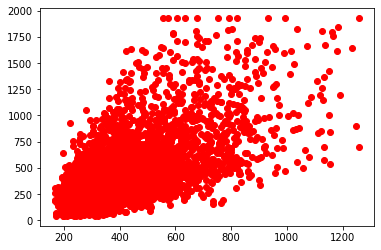

In [54]:
plt.scatter(train.pred_crdspent,train.crdspent,color ='r')
plt.show()

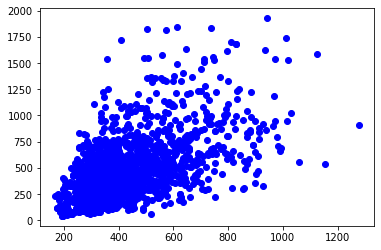

In [55]:
plt.scatter(test.pred_crdspent,test.crdspent,color ='b')
plt.show()

In [56]:
RMSE_train = np.sqrt(mean_squared_error(train.crdspent ,train.pred_crdspent)).round(3)
RMSE_test = np.sqrt(mean_squared_error(test.crdspent ,test.pred_crdspent)).round(3)

# print the values of RMSE for train and test
print('RMSE of training data: ', RMSE_train,  ' | ', 'RMSE of testing data: ', RMSE_test)

RMSE of training data:  269.183  |  RMSE of testing data:  256.764


In [57]:
Corr_train = stats.stats.pearsonr(train.crdspent ,train.pred_crdspent)
Corr_test = stats.stats.pearsonr(test.crdspent ,test.pred_crdspent)

# print the values of Correlation for train and test
print('Correlation of training data: ', Corr_train,  ' | ', 'Correlation of testing data: ', Corr_test)

Correlation of training data:  (0.5939028232597722, 0.0)  |  Correlation of testing data:  (0.5560967518145041, 1.6698650513377816e-122)


In [58]:
MAPE_train = '%.3f' % np.mean(np.abs(train.crdspent - train.pred_crdspent)/train.crdspent)
MAPE_test = '%.3f' % np.mean(np.abs(test.crdspent - test.pred_crdspent)/test.crdspent)

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  0.480  |  MAPE of testing data:  0.475


In [59]:
train[['crdspent','pred_crdspent']]

,crdspent,pred_crdspent
4735,1107.07,427.666963
1796,349.01,454.030351
479,319.12,493.750879
2524,405.58,568.682009
1565,148.64,499.244136
...,...,...
664,358.54,339.932505
3276,161.35,349.262138
1318,699.91,607.554272
723,250.71,378.682535


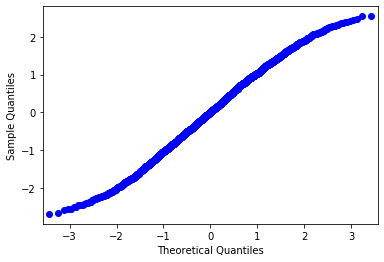

In [126]:
sm.qqplot(lm1.resid,fit = True)
plt.show()

### Determining Cook's D distance and removing influential points
### Threshold of 4/N or 4/(N−k−1), where N is the number of observations and k the number of explanatory variables.

In [133]:
infl=lm1.get_influence()

In [132]:
### Cook's D 

In [114]:
df_cookd=infl.summary_frame()

In [116]:
N=train.shape[0]

In [117]:
K=8 ### card + card2 + ed + gender + age +lninc + default + debtinc

In [118]:
drop_obs=list(df_cookd[ df_cookd.cooks_d >= (4/(N-K-1))].index)

In [119]:
### Regression Model after removing Influential points

In [120]:
train_new=train.drop(drop_obs)

In [121]:
train_new.drop(columns='pred_crdspent',inplace = True)
test.drop(columns='pred_crdspent',inplace = True)

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [122]:
model_param = '''ln_crdspent ~ card + card2 + ed + gender + age +lninc + default + debtinc'''

In [123]:
lm2 = smf.ols(model_param, train_new).fit()

In [124]:
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:            ln_crdspent   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     142.0
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:05:18   Log-Likelihood:                -2070.5
No. Observations:                3318   AIC:                             4171.
Df Residuals:                    3303   BIC:                             4263.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.8345      0.066     87.810   

In [125]:
train_new['pred_crdspent'] = np.exp(lm2.predict(train_new))
test['pred_crdspent'] = np.exp(lm2.predict(test))

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [126]:
RMSE_train = np.sqrt(mean_squared_error(train_new.crdspent ,train_new.pred_crdspent)).round(3)
RMSE_test = np.sqrt(mean_squared_error(test.crdspent ,test.pred_crdspent)).round(3)

# print the values of RMSE for train and test
print('RMSE of training data: ', RMSE_train,  ' | ', 'RMSE of testing data: ', RMSE_test)

RMSE of training data:  247.02  |  RMSE of testing data:  255.207


In [127]:
Corr_train = stats.stats.pearsonr(train_new.crdspent ,train_new.pred_crdspent)
Corr_test = stats.stats.pearsonr(test.crdspent ,test.pred_crdspent)

# print the values of Correlation for train and test
print('Correlation of training data: ', Corr_train,  ' | ', 'Correlation of testing data: ', Corr_test)

Correlation of training data:  (0.621814059866505, 0.0)  |  Correlation of testing data:  (0.5541018995002844, 1.8428544801685461e-121)


In [128]:
MAPE_train = '%.3f' % np.mean(np.abs(train_new.crdspent - train_new.pred_crdspent)/train_new.crdspent)
MAPE_test = '%.3f' % np.mean(np.abs(test.crdspent - test.pred_crdspent)/test.crdspent)

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  0.395  |  MAPE of testing data:  0.494


### Conclusion 

### Driving Factors for Credit Card Spent are :

card,card2,ed,gender,age,lninc,default,debtinc